In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL
from matplotlib import pyplot as plt

from merge.evaluation import load_model
import datasets.ICDAR.ICDAR
import datasets.FinTabNet.FinTabNet
from utils.visualization import create_merge_result_image

In [2]:
m = load_model('checkpoints/merge_fin_tab_net.ckpt', False)

2022-02-24 06:18:11.275880: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-02-24 06:18:11.813481: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open checkpoints/merge_fin_tab_net.ckpt: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [3]:
ds = tfds.load('fin_tab_net_merge', split='test')
ds = ds.shuffle(128, seed=42)

In [4]:
def get_predictions(ds_element):
    input_keys = [
        'image',
        'horz_split_points_probs',
        'vert_split_points_probs',
        'horz_split_points_binary',
        'vert_split_points_binary'
    ]
    inputs = {key: tf.expand_dims(ds_element[key], 0) for key in input_keys}
    
    outputs = m(inputs)
    return (
        tf.squeeze(outputs['merge_down_probs2'] >= 0.5, 0),
        tf.squeeze(outputs['merge_right_probs2'] >= 0.5, 0)
    )

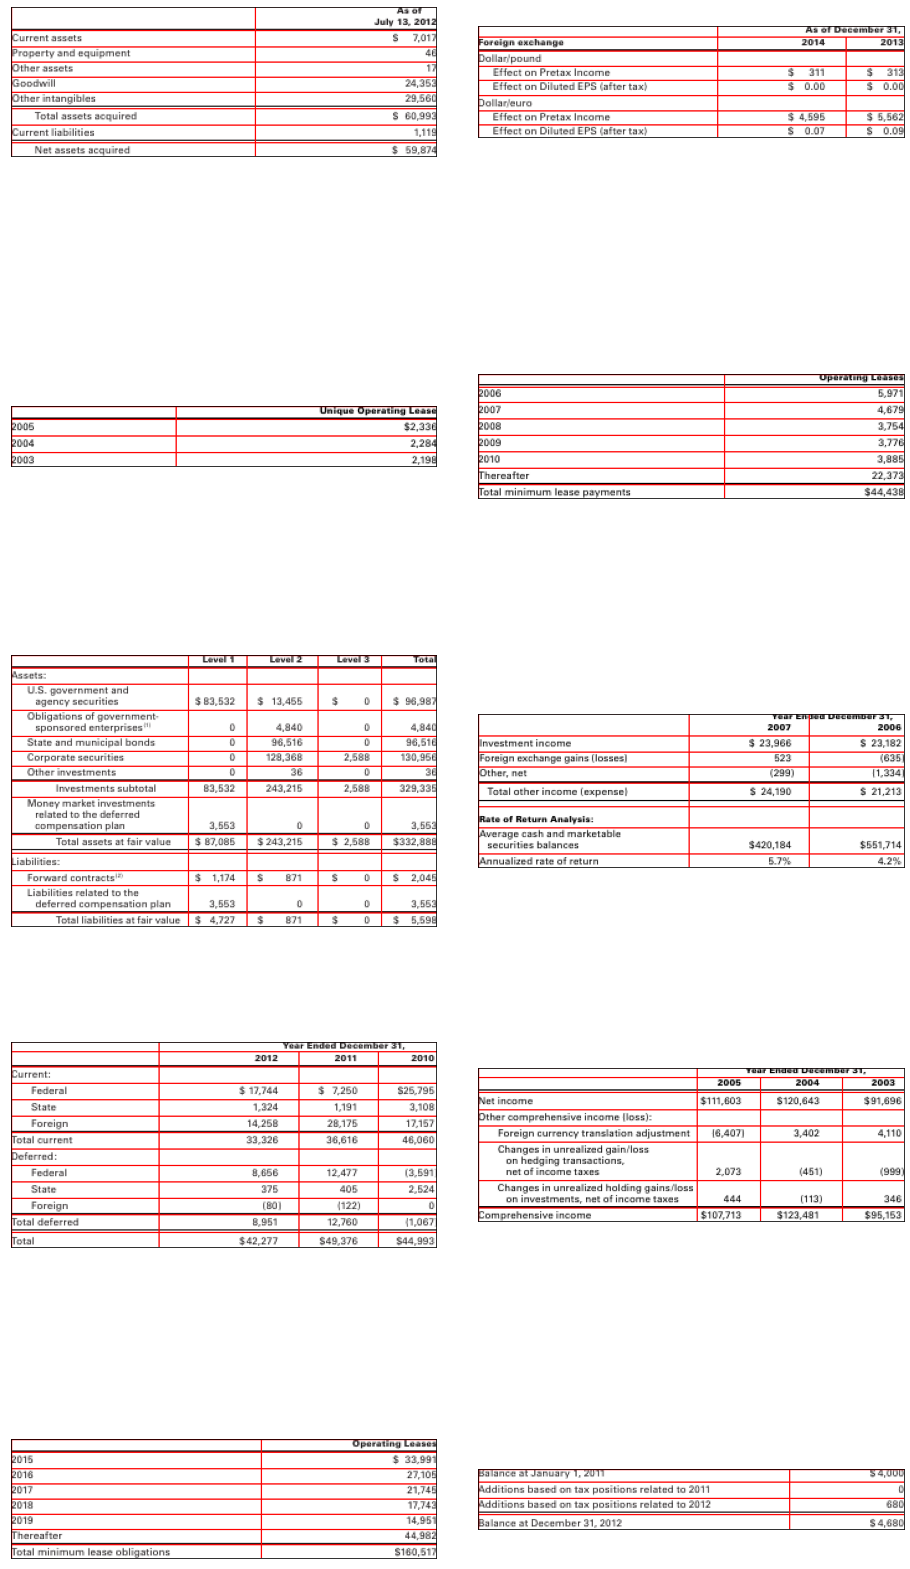

In [5]:
fig, axes = plt.subplots(5, 2, figsize=(16,32))

for element, ax in zip(ds.take(10), axes.flat):
    merge_down_mask, merge_right_mask = get_predictions(element)
    image = PIL.Image.fromarray(element['image'].numpy())
    h_mask = element['horz_split_points_binary'].numpy()
    v_mask = element['vert_split_points_binary'].numpy()
    debug_image = create_merge_result_image(
        image, h_mask, v_mask, merge_right_mask, merge_down_mask)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(debug_image)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig('images/merge_model_predictions.png', bbox_inches='tight')
plt.show()